# KBA Registration Data


In this section we describe our main data source. The Vehicle registration data is sourced from the **Kraftfahrt-Bundesamt (KBA)**, Germany's Federal Motor Transport Authority, specifically from the monthly [FZ10 statistical reports](https://www.kba.de/DE/Statistik/Produktkatalog/produkte/Fahrzeuge/fz10).

**Temporal Coverage**

- **Period:** January 2018 – October 2025
- **Frequency:** Monthly observations

**Features**

- **OEM (Original Equipment Manufacturer):** Vehicle manufacturer (e.g., BMW, Mercedes-Benz, Volkswagen)
- **Model:** Specific vehicle model (e.g., A-Class, X1, Golf)
- **Powertrain Types:**
  - Total registrations
  - Electric (BEV - Battery Electric Vehicles)
  - Hybrid (including Plug-in Hybrid)
  - Diesel
  - Petrol
- **Additional Features:** All-wheel drive, convertibles

In [3]:
import os
import pandas as pd
import sys 

## Functions

In [4]:
# Add the parent directory to sys.path to allow imports from neuralts
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from neuralts.data_preparation.data_cleaning_kba import data_cleaning

In [5]:
storage_path = "../data/processed/historical_kba_data.parquet"
df = pd.read_parquet(storage_path, engine='pyarrow')

df["ts_key_size"] = df.groupby('ts_key')['ts_key'].transform('size')

# FIlter ts_keys with at least 12 entries
df = df[df['ts_key_size'] >= 12].copy()

df.head()

,OEM,Model,drive_type,Value,Date,ts_key,ts_key_size
1745,ALFA ROMEO,GIULIA,All_Wheel_Drive,79.0,2022-10-31,ALFA ROMEO_GIULIA_All_Wheel_Drive,94
2094,ALFA ROMEO,GIULIA,Convertibles,0.0,2022-10-31,ALFA ROMEO_GIULIA_Convertibles,94
698,ALFA ROMEO,GIULIA,Diesel,9.0,2022-10-31,ALFA ROMEO_GIULIA_Diesel,94
1047,ALFA ROMEO,GIULIA,Electric_BEV,0.0,2022-10-31,ALFA ROMEO_GIULIA_Electric_BEV,94
1396,ALFA ROMEO,GIULIA,Hybrid,0.0,2022-10-31,ALFA ROMEO_GIULIA_Hybrid,94


In [6]:
df['ts_key'].nunique()

3745

## Data Quality Checks

If we take into account all timeseries, we can observe that there is a total of 3,745 timeseries with at least 12 datapoints. However, in order to forecast our target folds, we need to make sure that all timeseries have values up to Oct 2025. 

In [7]:
df.groupby(['ts_key'])['Date'].max().value_counts()

Date
2025-10-31    2793
2019-12-31     203
2024-12-31     182
2022-12-31     133
2021-12-31     119
2020-12-31      98
2018-12-31      91
2023-12-31      70
2025-03-31      28
2024-10-31       7
2024-03-31       7
2022-10-31       7
2022-02-28       7
Name: count, dtype: int64

We can observer that most of the timeseries end in October 2025. We will then filter the dataset to only include timeseries that end in October 2025.

In [8]:
print("Max date:", df['Date'].max())

max_date = df['Date'].max()
ts_keys_with_max_date = df[df['Date'] == max_date]['ts_key'].unique()
df = df[df['ts_key'].isin(ts_keys_with_max_date)].copy()

print("Shape after cleaning:", df.shape)
print("Number of unique ts_keys:", df['ts_key'].nunique())

Max date: 2025-10-31 00:00:00
Shape after cleaning: (194264, 7)
Number of unique ts_keys: 2793


Addtionally we can observe that multiple timeseries contain 0 values for all the historical data. Let's filter out all timeseries with 0 values in the last 12 months, that is, no registration of that vehicle type has happened in the last 12 months. 

In [9]:
recent_12_months = df['Date'].max() - pd.DateOffset(months=12)
recent_data = df[df['Date'] > recent_12_months]

# Remove ts_keys with all zero values in the last 12 months
zero_value_ts_keys = recent_data.groupby('ts_key')['Value'].sum()
zero_value_ts_keys


ts_key
ALFA ROMEO_GIULIA_All_Wheel_Drive    634.0
ALFA ROMEO_GIULIA_Convertibles         0.0
ALFA ROMEO_GIULIA_Diesel              55.0
ALFA ROMEO_GIULIA_Electric_BEV         0.0
ALFA ROMEO_GIULIA_Hybrid               0.0
                                     ...  
XPENG_P7_Diesel                        0.0
XPENG_P7_Electric_BEV                144.0
XPENG_P7_Hybrid                        0.0
XPENG_P7_Petrol                        0.0
XPENG_P7_Total                       144.0
Name: Value, Length: 2793, dtype: float64

In [10]:
zero_value_ts_keys = zero_value_ts_keys[zero_value_ts_keys == 0].index
df = df[~df['ts_key'].isin(zero_value_ts_keys)].copy()

print("Final shape after cleaning:", df.shape)
print("Final number of unique ts_keys:", df['ts_key'].nunique())

Final shape after cleaning: (109424, 7)
Final number of unique ts_keys: 1502


Finally, since most of the additional features are only available up to Sep 2025, we will also limit our dataset to this date. 

In [11]:
df = df[df["Date"] < max_date].copy()

print("Final shape after cleaning:", df.shape)
print("Final number of unique ts_keys:", df['ts_key'].nunique())

Final shape after cleaning: (107922, 7)
Final number of unique ts_keys: 1502


In [12]:
df['Value'].describe()

count    107922.000000
mean        432.672152
std         874.724067
min          -4.000000
25%           4.000000
50%          88.000000
75%         459.000000
max       22335.000000
Name: Value, dtype: float64

We can observe that some values are negative, which is not possible for car sales. Therefore, we will set all negative values to zero.

In [13]:
# All negative values are set to zero
df.loc[df["Value"] < 0, "Value"] = 0

Finally let's observe which timeseries is behind the max value in the dataset. 

In [14]:
df.loc[df["Value"] == df["Value"].max(), "ts_key"].unique()

array(['VW_GOLF_Total'], dtype=object)

In [15]:
# Check all ts_keys containing values for "VW_GOLF"
df[df['ts_key'].str.contains("VW_GOLF")]['ts_key'].unique()

array(['VW_GOLF_All_Wheel_Drive', 'VW_GOLF_Diesel',
       'VW_GOLF_Electric_BEV', 'VW_GOLF_Hybrid', 'VW_GOLF_Petrol',
       'VW_GOLF_Total'], dtype=object)

## Data Analysis

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_vehicle_registrations(df, model):

    models = df[df['ts_key'].str.contains(model)]['ts_key'].unique()
    timeseries_key_list = models

    time_col = 'Date'

    plt.figure(figsize=(12, 6))

    for ts_key in timeseries_key_list:
        df_subset = df[df['ts_key'] == ts_key].copy()
        if not df_subset.empty:
            df_subset = df_subset.sort_values(by=time_col)
            sns.lineplot(data=df_subset, x=time_col, y='Value', marker='o', label=ts_key)
        else:
            print(f"No data found for {ts_key}")

    plt.title(f'Vehicle Registrations for {model} and Powertrains')
    plt.xlabel('Date')
    plt.ylabel('Registrations')
    plt.legend()
    plt.grid(True)
    plt.show()

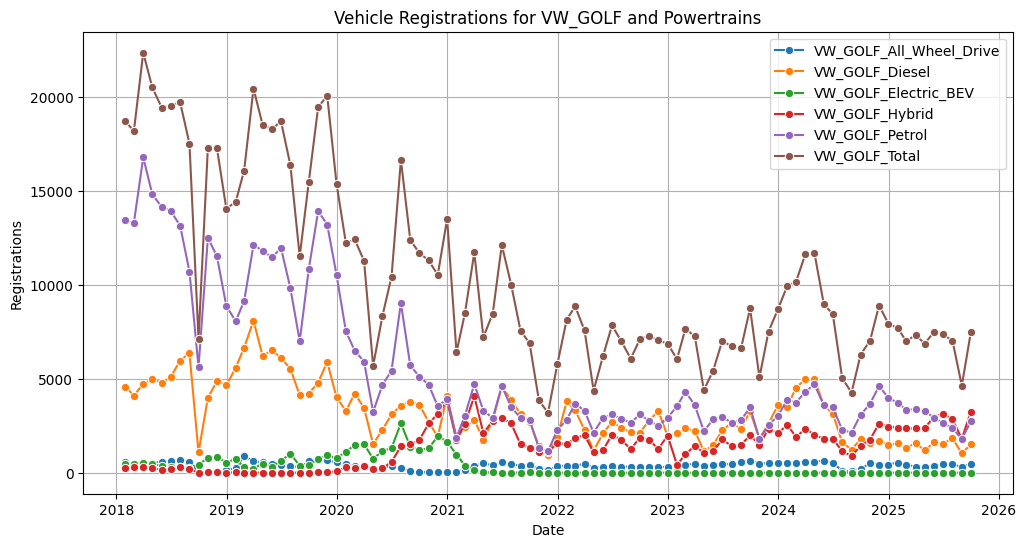

In [17]:
model = 'VW_GOLF'
plot_vehicle_registrations(df, model)

### VW Golf Registration Analysis

Now let's use the VW Golf, a mature mass-market model, as a basis to analyze the data across the multiple powertrains. In the chart above, we can observe that the monthly vehicle registration trends for the Volkswagen Golf across different powertrain types from January 2018 to September 2025. This example demonstrates several key characteristics present throughout the dataset. Some of the key observations are:

**Declining Total Volumes:** The total registrations (brown line) show a clear downward trend, declining from peaks of ~22,000 monthly registrations in 2018 to approximately 7,000 in 2025. This fact highlights the current economic crisis we observe in the news for VW.

**Powertrain Transition:**
Powertrain Transition: The data reveals a clear shift from conventional to alternative powertrains. Diesel registrations declined sharply from 6,000-8,000 to 1,000-2,000, while petrol decreased from ~15,000-17,000 to 2,000-4,000. Conversely, both Electric BEV and Hybrid variants grew from near-zero in 2018 to stabilize at 2,000-3,000 monthly registrations each by 2025, demonstrating the market's transition toward electrification.

**Structural Breaks:** A notable disruption is visible around 2020-2021, likely attributed to:
   - COVID-19 pandemic effects on automotive production and sales
   - Semiconductor chip shortage impacts
   - Regulatory changes and emission standards



These timeseries example demonstrates the complexity of automotive forecasting, requiring models capable of capturing trend changes, structural breaks, and seasonal patterns simultaneously across multiple interdependent series. We can say that the multiple timeseries are correlated to each other over the time. Therefore, models capable of leveraring this autocorrelation will probably demonstrate higher accuracy levels. 

Let's also plot representative models for Mercedes-Benz and BMW and compare the trend. 

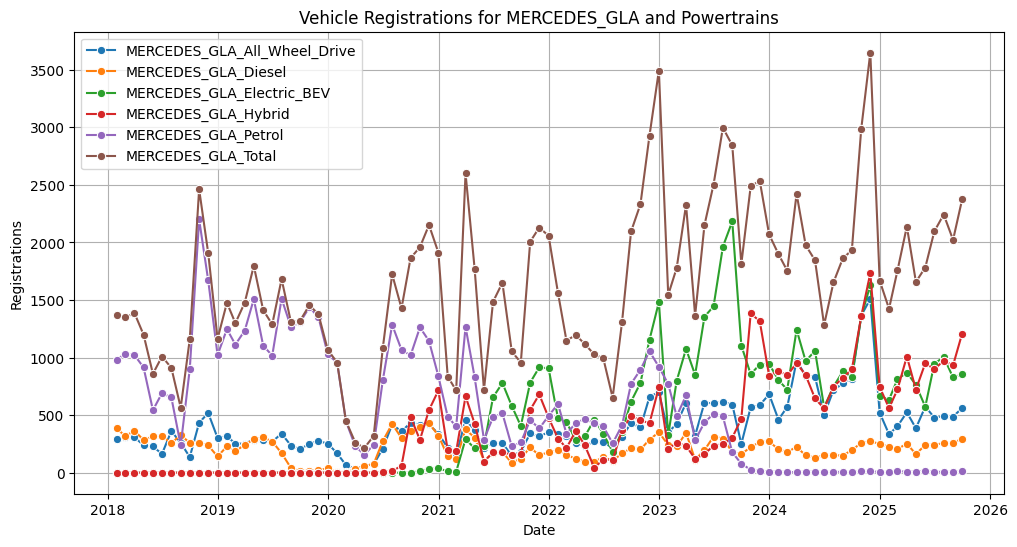

In [18]:
model = 'MERCEDES_GLA'
plot_vehicle_registrations(df, model)

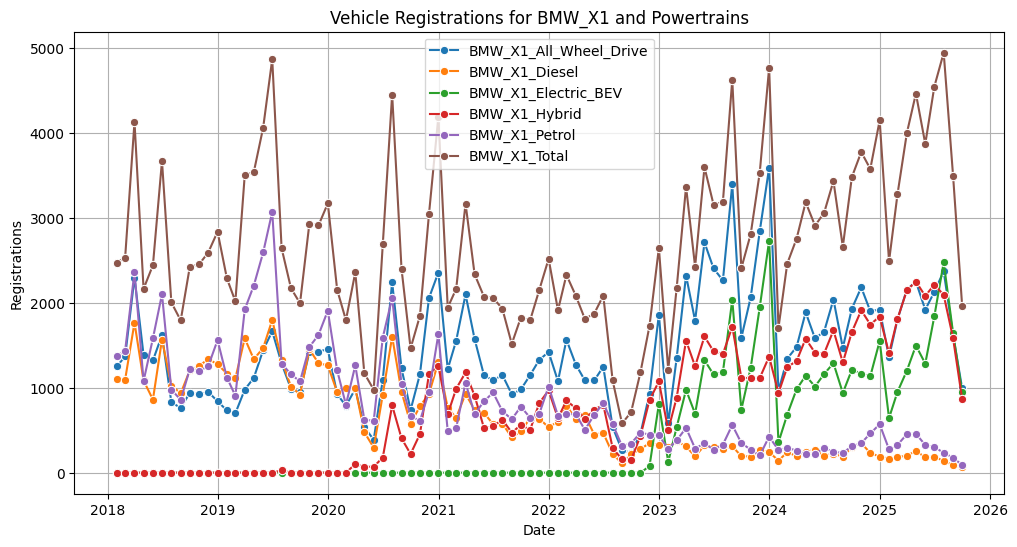

In [19]:
model = 'BMW_X1'
plot_vehicle_registrations(df, model)

### Analysis BWM X1 vs MERCEDES-BENZ GLA

We now focus on two well stablished model in the SUV segment. The two charts above illustrate the number of resgistered vehicles for BMW X1 and Mercedes-Benz GLA, from January 2018 until September 2025. We can highlight the following: 

**Powertrain Transition**: For both vehicles we observe a strong transition from Petrol to Hybrid and Battery Electric Vehicles starting in 2020. The Mercedes-Benz GLA seems to have positioned strongly in the BEV Segment starting off in mid 2021 until late 2023. After late 2023 the Mercedes-Benz GLA started to lose momemtum meanwhile the Hybrid option for the GLA started to catch up. On the other hand, BMW started a stronger stragegy in the Hybrid segment while only catching up in Battery Electric Vehicles in mid 2023. However, we can observe that the total registered volume of vehicles for BMW ranges from 2,000 to 5,000 vehicles, which is a higher volume that the one registered by Mercedes-Benz. 



In [ ]:
df.describe()

,Value,Date,ts_key_size,ts_length
count,107922.000000,107922,107922.000000,107922.000000
mean,432.672254,2022-03-27 00:59:01.757936640,83.590000,82.590000
min,0.000000,2018-01-31 00:00:00,12.000000,11.000000
25%,4.000000,2020-04-30 00:00:00,82.000000,81.000000
50%,88.000000,2022-05-31 00:00:00,94.000000,93.000000
75%,459.000000,2024-03-31 00:00:00,94.000000,93.000000
max,22335.000000,2025-09-30 00:00:00,94.000000,93.000000
std,874.724017,NaN,19.391184,19.391184


In [40]:
df['ts_length'] = df.groupby('ts_key')['Value'].transform('size')
df['ts_length'].describe()


count    107922.000000
mean         82.590000
std          19.391184
min          11.000000
25%          81.000000
50%          93.000000
75%          93.000000
max          93.000000
Name: ts_length, dtype: float64

All of theses data quality steps are condensed in a single function in the file `neuralts/data_preparation/gold_dataframe`. This function will be used in the generation of the gold dataset. 

In [ ]:
def apply_timeseries_cleaning(df: pd.DataFrame) -> pd.DataFrame:
    """Apply common time series cleaning steps to the DataFrame."""

    print("Initial shape before cleaning:", df.shape)
    print("Initial number of unique ts_keys:", df['ts_key'].nunique())

    # Apply some data Quality Checks for the timeseries     
    df["ts_key_size"] = df.groupby('ts_key')['ts_key'].transform('size')

    # Filter ts_keys with at least 12 entries
    df = df[df['ts_key_size'] >= 12].copy()

    # Do not include timeseries which have the last 12 months as zero values
    recent_12_months = df['Date'].max() - pd.DateOffset(months=12)
    recent_data = df[df['Date'] > recent_12_months]

    # Remove ts_keys with all zero values in the last 12 months
    zero_value_ts_keys = recent_data.groupby('ts_key')['Value'].sum()
    zero_value_ts_keys = zero_value_ts_keys[zero_value_ts_keys == 0].index
    df = df[~df['ts_key'].isin(zero_value_ts_keys)].copy()

    # keep only ts_key contain data until max date 
    max_date = df['Date'].max()
    ts_keys_with_max_date = df[df['Date'] == max_date]['ts_key'].unique()
    df = df[df['ts_key'].isin(ts_keys_with_max_date)].copy()

    # Limit data to < 31.10.2025, since most features are only available up to Sep 2025
    df = df[df["Date"] < "2025-10-31"].copy()

    # All negative values are set to zero
    df.loc[df["Value"] < 0, "Value"] = 0

    print("Final shape after cleaning:", df.shape)
    print("Final number of unique ts_keys:", df['ts_key'].nunique())

    return df

## Conclusions

After all the data quality checks, finally we get the dataframe we will use for forecasting. It can be described as following: 

- **Temporal Coverage:** January 2018 – October 2025 (monthly observations)
- **Total Data Points:** 107,922 observations
- **Average Series Length:** ~93 months per time series
- **Granularity:** Model-level registrations per powertrain type (e.g., BMW X1 Electric, Mercedes A-Class Diesel)